In [1]:
import numpy as np
import pandas as pd
import random
import cvxopt
from cvxopt import matrix, solvers
from cvxopt.modeling import variable
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from libsvm.svmutil import *
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
random.seed(42)

In [2]:
SUBSET = [False,2000] # if True, 2nd val is # of points 
N_FOLDS = 5 # k-Fold cross validation
NUM_FEATURES = 25 # <=25 for the given data
SPLIT = 0.75 # Test-train split (for individual)
MODE = 'LIBSVM' # 'LIBSVM', 'CVXOPT', 'SSMO'
BINARY_CLASSIFICATION = False # Binary classification/Multiclass
C1,C2 = 4,9 # Classes (0-9)
KERNEL = 'LINEAR' # 'LINEAR', 'POLY', 'RBF'
GAMMA = 0.001 # Gamma for RBF Kernel
C = 3.0 # C for L1 regularization
POWER = 2 # Power in Polynomial kernel
COEFF = 4 # Coefficient in Polynomial kernel
MAX_PASSES = 5 # Number of passes in SSMO
TOLERANCE = 1e-3 # Tolerance for SSMO

In [3]:
def getData():
    df = pd.read_csv('2019EE10577.csv',header=None)
    if BINARY_CLASSIFICATION:
        df = df[(df[25] == C1) | (df[25] == C2)]
    dataset = []
    for i,row in df.iterrows():
        xi = []
        for j in range(0,NUM_FEATURES):
            xi.append(row[j])
        if BINARY_CLASSIFICATION:
            if(row[25]==C1):
                xi.append(-1.0)
            else:
                xi.append(1.0)
        else:
            xi.append(row[25])
        dataset.append(xi)
    
    if SUBSET[0]==True:
        dataset = dataset[:SUBSET[1]]
    return dataset

In [4]:
def cross_validation_split(dataset):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / N_FOLDS)
    for i in range(N_FOLDS):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [5]:
dataset = getData()

In [6]:
dataset_split = cross_validation_split(dataset)

In [7]:
class SVM:
    def __init__(self,mode='CVXOPT',kernel='LINEAR',C = 3.0,gamma = 0.001, power = 2, coeff = 4, max_passes = 5, tol=1e-3):
        self.mode = mode
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.power = power
        self.coeff = coeff
        self.max_passes = max_passes
        self.tol = tol
    
    def fit(self,X,y):
        X = np.array(X)
        y = np.array(y)
        num_samples,num_features = X.shape
        K = np.zeros((num_samples,num_samples))
        
        for i in (range(num_samples)):
            for j in range(num_samples):
                if self.kernel == 'LINEAR':
                    K[i][j] = np.dot(X[i],np.transpose(X[j]))
                elif self.kernel == 'POLY':
                    K[i][j] = (np.dot(X[i],np.transpose(X[j])) + self.coeff) ** self.power
                elif self.kernel == 'RBF':
                    K[i][j] = np.exp(-1 * self.gamma*np.sum(np.square(X[i]-X[j])))
        
        self.K = K
        
        if self.mode == 'CVXOPT':
            H = np.zeros((num_samples,num_samples))
            for i in (range(num_samples)):
                for j in range(num_samples):
                    H[i][j] = y[i]*y[j] * K[i][j]
            P = matrix(H)
            q = matrix(np.ones(num_samples) * -1.)
            G = matrix(np.vstack(((np.identity(num_samples) * -1.),np.identity(num_samples))))
            h = matrix(np.hstack((np.zeros(num_samples),np.ones(num_samples)*self.C)))
            A = matrix(y,(1,num_samples))
            b = matrix(0.0)

            solvers.options['show_progress'] = False
            soln = solvers.qp(P,q,G,h,A,b)
            alpha = np.ravel(soln['x'])
            
            self.sup_idx = alpha > 1e-5
            self.ind =  np.arange(len(alpha))[self.sup_idx]
            self.sup_x = X[self.sup_idx,:]
            self.sup_y = y[self.sup_idx]
            self.alpha = alpha[self.sup_idx]
#             self.b = self.sup_y[0]

#             for i in range(len(self.alpha)):
#                 if self.kernel == 'LINEAR':
#                     temp = np.dot(self.sup_x[i],np.transpose(self.sup_x[0]))
#                 elif self.kernel == 'POLY':
#                     temp = (np.dot(self.sup_x[i],np.transpose(self.sup_x[0]))+self.coeff)**self.power
#                 elif self.kernel == 'RBF':
#                     temp = np.exp(-1 * self.gamma*np.sum(np.square(self.sup_x[i]-self.sup_x[0])))
#                 self.b -= self.alpha[i] * self.sup_y[i] * temp
            self.b = 0
            for i in range(len(self.alpha)):
                self.b += self.sup_y[i]
                self.b -= np.sum(self.alpha * self.sup_y * self.K[self.ind[i]][self.sup_idx])
            self.b /= len(self.alpha)
            self.sup_idx = np.where(self.sup_idx == True)[0]
            
        elif self.mode == 'SSMO':
            alpha = np.zeros((num_samples))
            alpha_old = np.zeros((num_samples))
            E = np.zeros((num_samples))
            b = 0
            passes = 0
            while(passes<self.max_passes):
                num_changed_alpha = 0
                for i in range(num_samples):
                    E[i] = np.sum(alpha * y * self.K[:,i]) + b - y[i]

                    if (y[i] * E[i] < -self.tol and alpha[i]<self.C) or (y[i] * E[i] > self.tol and alpha[i]>0):
                        j = random.randint(0,num_samples-1)
                        while j == i:
                            j = random.randint(0,num_samples-1)

                        E[j] = np.sum(alpha * y * self.K[:,j]) + b - y[j]
                        alpha_old[i] = alpha[i]
                        alpha_old[j] = alpha[j]

                        if y[i] != y[j]:
                            L = max(0,alpha[j] - alpha[i])
                            H = min(self.C,self.C+alpha[j] - alpha[i])
                        else:
                            L = max(0,alpha[i]+alpha[j] - self.C)
                            H = min(self.C,alpha[i] + alpha[j])

                        if L==H:
                            continue

                        eta = 2* self.K[i][j] - self.K[i][i] - self.K[j][j]

                        if eta>=0:
                            continue

                        alpha[j] = alpha[j] - y[j] * (E[i] - E[j])/eta

                        if alpha[j]>H:
                            alpha[j] = H
                        elif alpha[j]<L:
                            alpha[j] = L

                        if abs(alpha[j] - alpha_old[j]) < 1e-5:
                            continue

                        alpha[i] = alpha[i] + y[i]* y[j] * (alpha_old[j] - alpha[j])

                        b1 = b - E[i] - y[i] * (alpha[i] - alpha_old[i]) * self.K[i][i] \
                            - y[j] * (alpha[j] - alpha_old[j]) * self.K[i][j]
                        b2 = b - E[j] - y[i] * (alpha[i] - alpha_old[i]) * self.K[i][j] \
                            - y[j] * (alpha[j] - alpha_old[j]) * self.K[j][j] 

                        if 0<alpha[i] and alpha[i] <self.C:
                            b = b1
                        elif 0<alpha[j] and alpha[j] < self.C:
                            b = b2
                        else:
                            b = (b1+b2)/2

                        num_changed_alpha +=1

                if num_changed_alpha == 0:
                    passes+=1
                else:
                    passes=0

            self.b = b
            self.sup_idx = np.where(alpha>0)[0]
            self.sup_x = X[self.sup_idx,:]
            self.sup_y = y[self.sup_idx]
            self.alpha = alpha[self.sup_idx]
            self.w = np.dot(alpha*y,X).T
        
    def predict(self,X):
        preds = []
        for x in X:
            pred = 0
            for i in range(len(self.alpha)):
                if self.kernel == 'LINEAR':
                    temp = np.dot(self.sup_x[i],np.transpose(x))
                elif self.kernel == 'POLY':
                    temp = (np.dot(self.sup_x[i],np.transpose(x)) + self.coeff) ** self.power
                elif self.kernel == 'RBF':
                    temp = np.exp(-1 * self.gamma *np.sum(np.square(self.sup_x[i]-x)))
                pred += self.alpha[i] * self.sup_y[i] * temp
            pred += self.b
            if pred>=0:
                preds.append(1.0)
            else:
                preds.append(-1.0)
        return np.array(preds)

In [8]:
def getAccuracy(preds,testY):
    if len(testY) == 0:
        return 100
    correct = 0
    for i in range(len(testY)):
        if preds[i] == testY[i]:
            correct +=1
    return correct/len(testY) * 100

In [9]:
def evaluateCrossEval(dataset_split):
    train_acc_list = []
    test_acc_list = []
    for fold in (dataset_split):
        trainDS = list(dataset_split)
        trainDS.remove(fold)
        trainDS = sum(trainDS,[])
        testDS = list()
        
        for row in fold:
            rowCopy = list(row)
            testDS.append(rowCopy)
        
        trainX = [train[:-1] for train in trainDS]
        trainY = [train[-1] for train in trainDS]
        
        testX = [test[:-1] for test in testDS]
        testY = [test[-1] for test in testDS]
        
        if BINARY_CLASSIFICATION == False or MODE == 'LIBSVM':
            prob = svm_problem(trainY,trainX)
            param = svm_parameter()
            kernel_string_map = {
                'LINEAR': LINEAR,
                'POLY': POLY,
                'RBF': RBF
            }
            param.kernel_type = kernel_string_map[KERNEL]
            param.C = C
            param.gamma = GAMMA
            param.degree = POWER
            param.coef0 = COEFF
            m = svm_train(prob,param,'-q')
            t_label, t_acc, t_val = svm_predict(trainY, trainX, m,'-q')
            p_label, p_acc, p_val = svm_predict(testY, testX, m,'-q')
            train_acc_list.append(t_acc[0])
            test_acc_list.append(p_acc[0])
        else:
            cf = SVM(mode=MODE,kernel=KERNEL,gamma=GAMMA,C=C,power=POWER,coeff=COEFF,max_passes=MAX_PASSES,tol=TOLERANCE)
            cf.fit(trainX,trainY)
            
            train_preds = cf.predict(trainX)
            test_preds = cf.predict(testX)
            
            train_acc = getAccuracy(train_preds,trainY)
            test_acc = getAccuracy(test_preds,testY)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
    
    return np.mean(train_acc_list),np.mean(test_acc_list)

In [10]:
evaluateCrossEval(dataset_split)

(95.38333333333335, 88.66666666666667)

In [11]:
# for MODE in ['LIBSVM', 'CVXOPT', 'SSMO']:
#     starttime = datetime.now()
#     _,acc = evaluate(dataset_split)
#     endtime = datetime.now()
#     duration = (endtime-starttime)
#     duration = duration
#     print(MODE,acc,duration)

In [11]:
def evaluateSplit(dataset):
    n = len(dataset)
    trainDS = dataset[:int(SPLIT*n)]
    testDS = dataset[int(SPLIT*n):]
    
    trainX = [train[:-1] for train in trainDS]
    trainY = [train[-1] for train in trainDS]

    testX = [test[:-1] for test in testDS]
    testY = [test[-1] for test in testDS]
    
    if BINARY_CLASSIFICATION == False or MODE == 'LIBSVM':
        prob = svm_problem(trainY,trainX)
        param = svm_parameter()
        kernel_string_map = {
            'LINEAR': LINEAR,
            'POLY': POLY,
            'RBF': RBF
        }
        param.kernel_type = kernel_string_map[KERNEL]
        param.C = C
        param.gamma = GAMMA
        param.degree = POWER
        param.coef0 = COEFF
        m = svm_train(prob,param,'-q')
        t_label, t_acc, t_val = svm_predict(trainY, trainX, m,'-q')
        p_label, p_acc, p_val = svm_predict(testY, testX, m,'-q')
        
        s = SVC(kernel=KERNEL.lower(),C = C,gamma=GAMMA)
        s.fit(trainX,trainY)
        
        return s.support_,t_acc[0],p_acc[0]
    else:
        cf = SVM(mode=MODE,kernel=KERNEL,gamma=GAMMA,C=C,power=POWER,coeff=COEFF,max_passes=MAX_PASSES,tol=TOLERANCE)
        cf.fit(trainX,trainY)

        train_preds = cf.predict(trainX)
        test_preds = cf.predict(testX)

        train_acc = getAccuracy(train_preds,trainY)
        test_acc = getAccuracy(test_preds,testY)
        return cf.sup_idx,train_acc,test_acc
    

In [13]:
KERNEL = "LINEAR"
MODE = "LIBSVM"

In [34]:
train_acc_list = []
test_acc_list = []
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

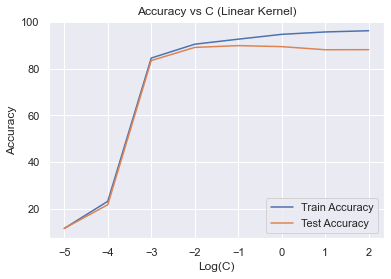

In [35]:
X = [-5,-4,-3,-2,-1,0,1,2]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (Linear Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (Linear Kernel).png',dpi=1200)
plt.show()


In [36]:
KERNEL = "RBF"

In [70]:
train_acc_list = []
test_acc_list = []
#GAMMA = 0.03
GAMMA = 1/(NUM_FEATURES)
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 11.533333333333333 11.533333333333335
0.0001 11.533333333333333 11.533333333333335
0.001 11.533333333333333 11.533333333333335
0.01 21.791666666666664 21.566666666666666
0.1 91.875 89.86666666666665
1.0 98.51666666666668 94.3
10.0 100.0 94.76666666666668
100.0 100.0 94.73333333333335


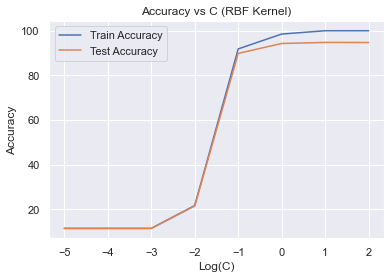

In [71]:
X = [-5,-4,-3,-2,-1,0,1,2]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (RBF Kernel).png',dpi=1200)
plt.show()

In [72]:
train_acc_list = []
test_acc_list = []
C = 1
for GAMMA in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(GAMMA,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 11.533333333333333 11.533333333333335
0.0001 52.85 52.53333333333334
0.001 87.50833333333333 86.56666666666668
0.01 94.11666666666666 91.99999999999999
0.1 99.83333333333334 93.9
1.0 100.0 21.23333333333333
10.0 100.0 11.6


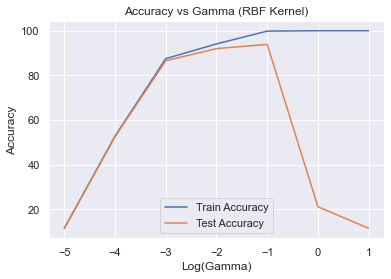

In [73]:
X = [-5,-4,-3,-2,-1,0,1]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(Gamma)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gamma (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs Gamma (RBF Kernel).png',dpi=1200)
plt.show()

In [ ]:
# Binary Classification from here:

In [80]:
KERNEL = "LINEAR"
MODE = "LIBSVM"

In [83]:
train_acc_list = []
test_acc_list = []
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 51.04838709677419 48.225806451612904
0.0001 52.741935483870975 49.516129032258064
0.001 94.87903225806451 94.19354838709678
0.01 96.49193548387098 96.45161290322581
0.1 97.98387096774194 97.25806451612902
1.0 98.62903225806451 96.29032258064517
10.0 99.03225806451613 95.80645161290323
100.0 99.39516129032258 95.0
1000.0 99.51612903225806 95.48387096774195


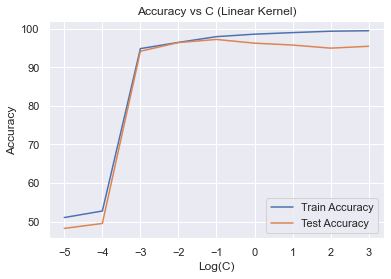

In [84]:
X = [-5,-4,-3,-2,-1,0,1,2,3]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (Linear Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (Linear Kernel).png',dpi=1200)
plt.show()

In [85]:
KERNEL = "RBF"

In [87]:
train_acc_list = []
test_acc_list = []
#GAMMA = 0.03
GAMMA = 1/(NUM_FEATURES)
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 51.04838709677419 48.225806451612904
0.0001 51.04838709677419 48.225806451612904
0.001 51.04838709677419 48.225806451612904
0.01 84.31451612903226 83.54838709677419
0.1 97.70161290322581 97.25806451612902
1.0 99.4758064516129 98.54838709677418
10.0 100.0 98.06451612903226
100.0 100.0 98.38709677419354
1000.0 100.0 98.38709677419354


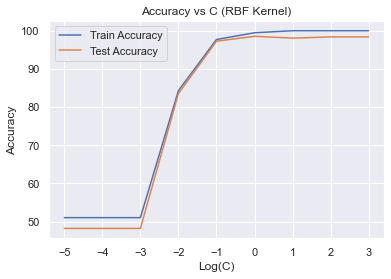

In [88]:
X = [-5,-4,-3,-2,-1,0,1,2,3]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (RBF Kernel).png',dpi=1200)
plt.show()

In [90]:
train_acc_list = []
test_acc_list = []
C = 1
for GAMMA in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(GAMMA,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-06 51.04838709677419 48.225806451612904
1e-05 51.04838709677419 48.225806451612904
0.0001 85.44354838709678 85.48387096774192
0.001 95.7258064516129 95.3225806451613
0.01 98.54838709677419 98.06451612903226
0.1 99.51612903225808 97.9032258064516
1.0 100.0 85.48387096774194
10.0 100.0 48.54838709677419
100.0 100.0 48.225806451612904


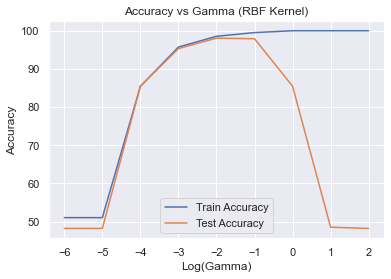

In [91]:
X = [-6,-5,-4,-3,-2,-1,0,1,2]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(Gamma)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gamma (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs Gamma (RBF Kernel).png',dpi=1200)
plt.show()

In [92]:
C1,C2 = 3,7

In [95]:
KERNEL = "LINEAR"
MODE = "LIBSVM"

In [96]:
train_acc_list = []
test_acc_list = []
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 59.88970588235294 59.11764705882352
0.0001 80.51470588235294 79.70588235294119
0.001 97.27941176470588 96.91176470588235
0.01 98.08823529411764 97.79411764705881
0.1 98.67647058823528 97.64705882352942
1.0 99.19117647058825 96.91176470588235
10.0 99.70588235294117 95.58823529411765
100.0 99.96323529411765 95.44117647058823
1000.0 100.0 95.58823529411765


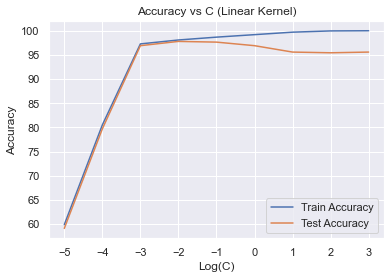

In [97]:
X = [-5,-4,-3,-2,-1,0,1,2,3]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (Linear Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (Linear Kernel).png',dpi=1200)
plt.show()

In [98]:
KERNEL = "RBF"

In [99]:
train_acc_list = []
test_acc_list = []
#GAMMA = 0.03
GAMMA = 1/(NUM_FEATURES)
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 60.441176470588246 59.55882352941177
0.0001 60.441176470588246 59.55882352941177
0.001 60.441176470588246 59.55882352941177
0.01 67.72058823529412 66.17647058823529
0.1 98.78676470588235 98.23529411764706
1.0 99.66911764705881 98.97058823529412
10.0 100.0 98.52941176470588
100.0 100.0 98.52941176470588
1000.0 100.0 98.52941176470588


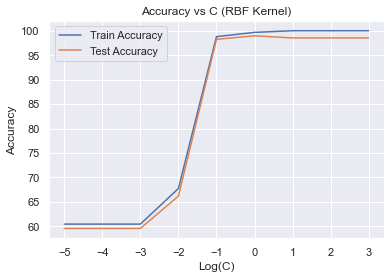

In [100]:
X = [-5,-4,-3,-2,-1,0,1,2,3]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (RBF Kernel).png',dpi=1200)
plt.show()

In [103]:
train_acc_list = []
test_acc_list = []
C = 1
for GAMMA in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(GAMMA,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-06 59.88970588235294 59.11764705882352
1e-05 59.88970588235294 59.11764705882352
0.0001 96.39705882352942 96.02941176470588
0.001 97.57352941176471 97.20588235294119
0.01 98.78676470588235 98.23529411764706
0.1 100.0 97.94117647058823
1.0 100.0 59.705882352941174
10.0 100.0 50.882352941176464


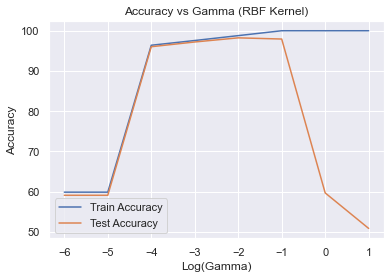

In [105]:
X = [-6,-5,-4,-3,-2,-1,0,1]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(Gamma)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gamma (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs Gamma (RBF Kernel).png',dpi=1200)
plt.show()

In [106]:
C1,C2 = 4,9

In [112]:
KERNEL = "LINEAR"
MODE = "LIBSVM"

In [114]:
train_acc_list = []
test_acc_list = []
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 51.50442477876106 51.50442477876106
0.0001 51.50442477876106 51.50442477876106
0.001 90.57522123893806 89.38053097345133
0.01 95.61946902654867 95.04424778761062
0.1 96.81415929203538 95.39823008849557
1.0 98.00884955752213 96.28318584070796
10.0 98.53982300884954 95.04424778761062
100.0 98.76106194690266 93.98230088495575


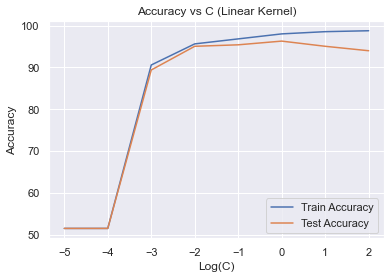

In [115]:
X = [-5,-4,-3,-2,-1,0,1,2]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (Linear Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (Linear Kernel).png',dpi=1200)
plt.show()

In [116]:
KERNEL = "RBF"

In [117]:
train_acc_list = []
test_acc_list = []
#GAMMA = 0.03
GAMMA = 1/(NUM_FEATURES)
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 51.50442477876106 51.50442477876106
0.0001 51.50442477876106 51.50442477876106
0.001 51.50442477876106 51.50442477876106
0.01 51.50442477876106 51.50442477876106
0.1 94.91150442477876 93.80530973451326
1.0 98.80530973451327 97.34513274336283
10.0 100.0 97.52212389380531
100.0 100.0 97.52212389380531
1000.0 100.0 97.52212389380531


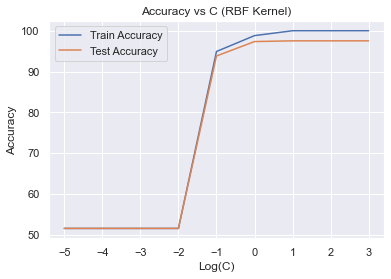

In [118]:
X = [-5,-4,-3,-2,-1,0,1,2,3]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (RBF Kernel).png',dpi=1200)
plt.show()

In [119]:
train_acc_list = []
test_acc_list = []
C = 1
for GAMMA in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(GAMMA,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-06 51.50442477876106 51.50442477876106
1e-05 51.50442477876106 51.50442477876106
0.0001 51.50442477876106 51.50442477876106
0.001 93.1858407079646 92.56637168141593
0.01 96.72566371681414 95.22123893805309
0.1 99.69026548672568 96.81415929203538
1.0 100.0 52.21238938053098
10.0 100.0 51.50442477876106


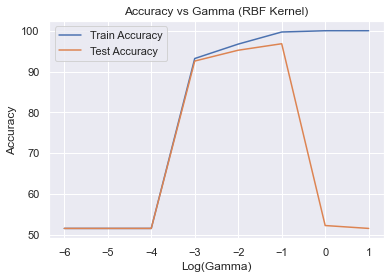

In [120]:
X = [-6,-5,-4,-3,-2,-1,0,1]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(Gamma)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gamma (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs Gamma (RBF Kernel).png',dpi=1200)
plt.show()

In [138]:
MODE = "LIBSVM"
KERNEL = "POLY"
COEFF = 0
train_acc_list = []
test_acc_list = []
POWER = 1
for C in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-06 51.50442477876106 51.50442477876106
1e-05 51.50442477876106 51.50442477876106
0.0001 90.57522123893806 89.38053097345133
0.001 95.61946902654867 95.04424778761062
0.01 96.81415929203538 95.39823008849557
0.1 98.00884955752213 96.28318584070796
1.0 98.53982300884954 95.04424778761062
10.0 98.76106194690266 93.98230088495575


In [149]:
KERNEL = "LINEAR"
C = 0.1
GAMMA = 0.1
MAX_PASSES = 5
C1,C2 = 4,9
dataset = getData()
dataset_split = cross_validation_split(dataset)

In [150]:
for MODE in ['LIBSVM','CVXOPT', 'SSMO']:
    starttime = datetime.now()
    trainacc,testacc = evaluateCrossEval(dataset_split)
    endtime = datetime.now()
    duration = (endtime-starttime)
    duration = duration
    print(MODE,trainacc,testacc,duration)

LIBSVM 97.0796460176991 96.10619469026547 0:00:00.150144
CVXOPT 96.99115044247787 95.75221238938052 0:00:06.162015
SSMO 97.03539823008848 96.10619469026548 0:00:17.039943


In [145]:
KERNEL = "RBF"
C = 1
GAMMA = 0.1
MAX_PASSES = 5
C1,C2 = 4,9
dataset = getData()
dataset_split = cross_validation_split(dataset)

In [146]:
for MODE in ['LIBSVM','CVXOPT', 'SSMO']:
    starttime = datetime.now()
    trainacc,testacc = evaluateCrossEval(dataset_split)
    endtime = datetime.now()
    duration = (endtime-starttime)
    duration = duration
    print(MODE,trainacc,testacc,duration)

LIBSVM 99.64601769911505 97.34513274336283 0:00:00.219928
CVXOPT 99.69026548672568 97.16814159292035 0:00:19.763364
SSMO 99.64601769911505 97.34513274336283 0:00:20.779926


In [118]:
KERNEL = "LINEAR"
C = 0.1
GAMMA = 0.1
MAX_PASSES = 5
C1,C2 = 1,8
dataset = getData()
dataset_split = cross_validation_split(dataset)

In [144]:
for MODE in ['LIBSVM','CVXOPT', 'SSMO']:
    starttime = datetime.now()
    trainacc,testacc = evaluateCrossEval(dataset_split)
    endtime = datetime.now()
    duration = (endtime-starttime)
    duration = duration
    print(MODE,trainacc,testacc,duration)

LIBSVM 98.0241935483871 97.25806451612902 0:00:00.160021
CVXOPT 97.94354838709677 97.09677419354838 0:00:06.822120
SSMO 97.8225806451613 97.25806451612902 0:00:13.569374


In [147]:
KERNEL = "RBF"
C = 1
GAMMA = 0.01
MAX_PASSES = 5
C1,C2 = 1,8
dataset = getData()
dataset_split = cross_validation_split(dataset)

In [148]:
for MODE in ['LIBSVM','CVXOPT', 'SSMO']:
    starttime = datetime.now()
    trainacc,testacc = evaluateCrossEval(dataset_split)
    endtime = datetime.now()
    duration = (endtime-starttime)
    duration = duration
    print(MODE,trainacc,testacc,duration)

LIBSVM 98.30645161290322 98.06451612903224 0:00:00.171265
CVXOPT 98.46774193548387 98.06451612903224 0:00:14.654499
SSMO 98.26612903225806 98.2258064516129 0:00:21.069174


In [151]:
KERNEL = "RBF"
C = 1
GAMMA = 0.01
MAX_PASSES = 5
C1,C2 = 1,8
dataset = getData()

In [160]:
for MODE in ['LIBSVM','CVXOPT', 'SSMO']:
    idx,trainacc,testacc = evaluateSplit(dataset)
    idx = sorted(idx)
    print(f"Mode: {MODE}")
    print(f"Training Accuracy: {trainacc}")
    print(f"Testing Accuracy: {testacc}")
    print(f'{len(idx)} number of support vectors found')
    print(f"The indices of the support vectors are: {idx}")
    print()

Mode: LIBSVM
Training Accuracy: 98.49785407725322
Testing Accuracy: 96.15384615384616
38 number of support vectors found
The indices of the support vectors are: [5, 13, 17, 21, 31, 36, 46, 56, 60, 78, 80, 86, 91, 111, 115, 118, 119, 143, 148, 161, 168, 182, 221, 245, 259, 281, 317, 339, 342, 343, 345, 351, 352, 359, 372, 395, 399, 401]

Mode: CVXOPT
Training Accuracy: 98.49785407725322
Testing Accuracy: 96.15384615384616
38 number of support vectors found
The indices of the support vectors are: [5, 13, 17, 21, 31, 36, 46, 56, 60, 78, 80, 86, 91, 111, 115, 118, 119, 143, 148, 161, 168, 182, 221, 245, 259, 281, 317, 339, 342, 343, 345, 351, 352, 359, 372, 395, 399, 401]

Mode: SSMO
Training Accuracy: 98.49785407725322
Testing Accuracy: 96.15384615384616
39 number of support vectors found
The indices of the support vectors are: [5, 13, 17, 21, 31, 36, 46, 56, 60, 78, 80, 86, 91, 111, 115, 118, 119, 143, 148, 161, 168, 182, 221, 245, 259, 281, 317, 339, 342, 343, 345, 351, 352, 356, 359, 3

In [163]:
KERNEL = "LINEAR"
C = 0.1
GAMMA = 0.1
MAX_PASSES = 5
C1,C2 = 1,8
dataset = getData()
MAX_PASSES = 8

In [164]:
for MODE in ['LIBSVM','CVXOPT', 'SSMO']:
    idx,trainacc,testacc = evaluateSplit(dataset)
    idx = sorted(idx)
    print(f"Mode: {MODE}")
    print(f"Training Accuracy: {trainacc}")
    print(f"Testing Accuracy: {testacc}")
    print(f'{len(idx)} number of support vectors found')
    print(f"The indices of the support vectors are: {idx}")
    print()

Mode: LIBSVM
Training Accuracy: 97.63948497854076
Testing Accuracy: 97.43589743589743
63 number of support vectors found
The indices of the support vectors are: [5, 11, 13, 15, 22, 31, 36, 40, 44, 46, 56, 60, 63, 76, 78, 80, 86, 91, 111, 115, 118, 138, 139, 143, 148, 151, 153, 161, 168, 172, 182, 210, 221, 236, 242, 245, 246, 259, 281, 293, 300, 305, 307, 310, 317, 322, 339, 342, 343, 345, 351, 356, 359, 360, 367, 372, 394, 395, 398, 399, 401, 417, 462]

Mode: CVXOPT
Training Accuracy: 97.63948497854076
Testing Accuracy: 97.43589743589743
63 number of support vectors found
The indices of the support vectors are: [5, 11, 13, 15, 22, 31, 36, 40, 44, 46, 56, 60, 63, 76, 78, 80, 86, 91, 111, 115, 118, 138, 139, 143, 148, 151, 153, 161, 168, 172, 182, 210, 221, 236, 242, 245, 246, 259, 281, 293, 300, 305, 307, 310, 317, 322, 339, 342, 343, 345, 351, 356, 359, 360, 367, 372, 394, 395, 398, 399, 401, 417, 462]

Mode: SSMO
Training Accuracy: 97.63948497854076
Testing Accuracy: 97.4358974358974

In [165]:
KERNEL = "LINEAR"
C = 0.1
GAMMA = 0.1
MAX_PASSES = 5
C1,C2 = 4,9
dataset = getData()

In [166]:
for MODE in ['LIBSVM','CVXOPT', 'SSMO']:
    idx,trainacc,testacc = evaluateSplit(dataset)
    idx = sorted(idx)
    print(f"Mode: {MODE}")
    print(f"Training Accuracy: {trainacc}")
    print(f"Testing Accuracy: {testacc}")
    print(f'{len(idx)} number of support vectors found')
    print(f"The indices of the support vectors are: {idx}")
    print()

Mode: LIBSVM
Training Accuracy: 96.93396226415094
Testing Accuracy: 96.47887323943662
89 number of support vectors found
The indices of the support vectors are: [2, 3, 5, 8, 12, 13, 14, 15, 16, 18, 21, 24, 26, 27, 30, 33, 36, 50, 56, 58, 64, 73, 74, 80, 81, 83, 93, 103, 104, 110, 123, 125, 136, 137, 144, 148, 157, 166, 167, 168, 170, 173, 174, 175, 177, 178, 179, 188, 196, 197, 205, 214, 219, 232, 233, 242, 244, 246, 255, 257, 261, 262, 266, 272, 275, 289, 293, 295, 306, 307, 318, 334, 336, 341, 344, 349, 358, 360, 364, 370, 382, 387, 389, 390, 394, 396, 406, 409, 410]

Mode: CVXOPT
Training Accuracy: 97.16981132075472
Testing Accuracy: 97.1830985915493
89 number of support vectors found
The indices of the support vectors are: [2, 3, 5, 8, 12, 13, 14, 15, 16, 18, 21, 24, 26, 27, 30, 33, 36, 50, 56, 58, 64, 73, 74, 80, 81, 83, 93, 103, 104, 110, 123, 125, 136, 137, 144, 148, 157, 166, 167, 168, 170, 173, 174, 175, 177, 178, 179, 188, 196, 197, 205, 214, 219, 232, 233, 242, 244, 246, 255

In [167]:
KERNEL = "RBF"
C = 1
GAMMA = 0.1
MAX_PASSES = 5
C1,C2 = 4,9
dataset = getData()

In [168]:
for MODE in ['LIBSVM','CVXOPT', 'SSMO']:
    idx,trainacc,testacc = evaluateSplit(dataset)
    idx = sorted(idx)
    print(f"Mode: {MODE}")
    print(f"Training Accuracy: {trainacc}")
    print(f"Testing Accuracy: {testacc}")
    print(f'{len(idx)} number of support vectors found')
    print(f"The indices of the support vectors are: {idx}")
    print()

Mode: LIBSVM
Training Accuracy: 99.76415094339622
Testing Accuracy: 97.1830985915493
319 number of support vectors found
The indices of the support vectors are: [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 42, 43, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95, 96, 98, 100, 101, 103, 104, 105, 107, 109, 110, 112, 114, 115, 116, 117, 119, 120, 121, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 136, 138, 141, 143, 144, 145, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 159, 161, 163, 164, 165, 166, 167, 168, 170, 172, 173, 174, 175, 177, 178, 179, 180, 182, 183, 185, 186, 187, 188, 189, 193, 194, 195, 196, 197, 198, 201, 202, 205, 206, 208, 210, 211, 212, 213, 214, 215, 217, 219, 220, 221, 223, 225, 226, 227, 228, 230, 232, 233, 235, 236, 237, 238, 240, 242, 244, 246,

In [12]:
KERNEL = "RBF"

In [13]:
def gridSearch():
    global C
    global GAMMA
    df = pd.DataFrame()
    bestC, bestG = 0,0
    bestAcc = 0
    for C in tqdm(np.arange(0.1,4.05,0.05)):
        for GAMMA in tqdm(np.arange(0.01,0.12,0.0025)):
            try:
                train_acc,test_acc = evaluateCrossEval(dataset_split)
                if test_acc>bestAcc:
                    bestC = C
                    bestG = GAMMA
                    bestAcc = test_acc
                it = {'C':C,'Gamma':GAMMA,'trainAcc':train_acc, 'testAcc':test_acc}
                df = df.append(it,ignore_index=True)
            except:
                continue
        df.to_csv('grid_pt1.csv',index=False)
    return bestC,bestG

In [14]:
bestC,bestGAMMA = gridSearch()

In [15]:
bestC,bestGAMMA

(2.400000000000001, 0.045000000000000005)

In [44]:
res = pd.read_csv('grid_pt1.csv')
res['Gamma']=np.array(round(res['Gamma'],5))
res['C']=np.array(round(res['C'],5))

In [45]:
res = res[res['testAcc'] > 93]

In [46]:
res2 = res.pivot(index='C',columns = 'Gamma',values='testAcc')

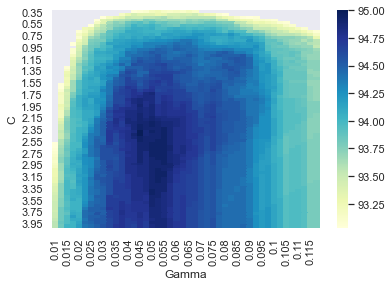

In [47]:
plt = sns.heatmap(res2,cmap="YlGnBu")
plt.figure.savefig('heatmap_pt1N.png',dpi=1200,bbox_inches='tight')

array([0.0425, 0.045 , 0.0475, ..., 0.1125, 0.115 , 0.1175])

In [25]:
KERNEL = 'RBF'
C = bestC
GAMMA = bestGAMMA
train_acc,test_acc = evaluateCrossEval(dataset_split)

In [26]:
train_acc

99.84166666666667

In [27]:
test_acc

95.0

In [29]:
KERNEL = "LINEAR"

In [32]:
def gridSearch():
    global C
    bestC = 0
    bestAcc = 0
    for C in tqdm(np.arange(0.01,0.12,0.002)):
        try:
            train_acc,test_acc = evaluateCrossEval(dataset_split)
            if test_acc>bestAcc:
                bestC = C
                bestAcc = test_acc
        except:
            continue
    return bestC

In [33]:
bestC = gridSearch()

In [34]:
bestC

0.058

In [35]:
C = bestC
train_acc,test_acc = evaluateCrossEval(dataset_split)
train_acc,test_acc

(92.06666666666668, 90.23333333333332)

In [37]:
KERNEL = "POLY"
C = 0.25
train_acc,test_acc = evaluateCrossEval(dataset_split)
train_acc,test_acc

(96.89999999999999, 92.73333333333332)